### Purpose of the Notebook :
Build a forecasting model that would be alerting sailors of the tacking event happening ahead.

In [1]:
# Importing relevant libraries

import numpy as np
import pandas as pd
import datetime as dt
import json
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
# Set seaborn style 
sns.set(style="darkgrid")
sns.set(font_scale=0.8)

#Processing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict,train_test_split,TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_curve, precision_score, recall_score, f1_score



# Fix the SEED
SEED = 42


#### Read Processed Data

In [2]:
data = pd.read_csv('./Data/processed_data.csv')
data.DateTime = pd.to_datetime(data.loc[:,'DateTime'])

# Adding Time based features 
data['hour_of_day'] = data.DateTime.dt.hour
data['minutes'] = data.DateTime.dt.minute
data['seconds'] = data.DateTime.dt.second

#### Split Data into Train, Holdout and Test 

In order to build our ML model and evaluate its performance, we need to divide our time series data into train and test sets. In machine learning, train_test_split function splits the data randomly, as there's no dependence from one observation to the other. That's not the case for Time Series data where an observation is dependent from the previous one and we want to capture the trend, so we don't want our observations to be randomly shuffled. We chose to split the data base on our timestamp. However, we need to make sure to have some tacking events in the test dataset as well. Both train and test sets should have observations of classes 0 and 1. 

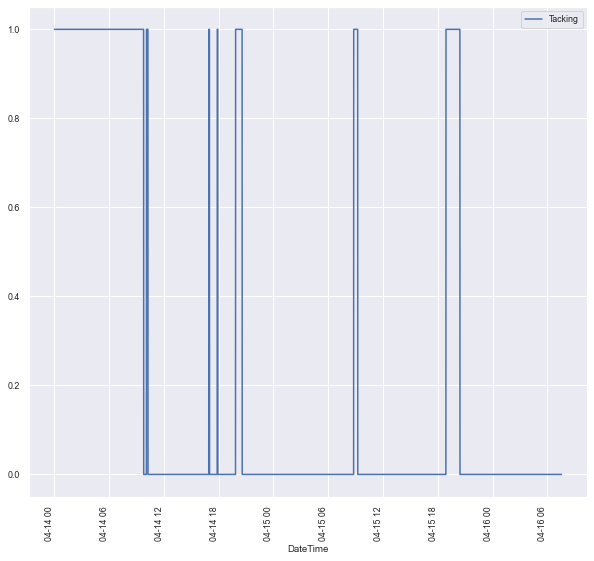

In [3]:
data.set_index('DateTime', inplace = True)
data['DateTime'] = data.index
data[['Tacking']].plot(subplots = True, color = 'b', figsize = (10,10),label = 'best')
plt.xticks(rotation = 'vertical')
plt.show() 

In [4]:
# Train dataset
train_mask = (data.index >= '2019-04-14 00:00:00') & (data.index < '2019-04-15 20:00:00')
train_data = data.loc[train_mask]

# Test dataset
test_mask = (data.index >= '2019-04-15 20:00:00') 
test_data = data.loc[test_mask]

As shown in the EDA notebook, we are dealing with unbalanced data set. Something to keep in mind while modeling. 

In [5]:
print('Train Data : Count of observations in each class')
labels = train_data['Tacking'].value_counts().reset_index()
labels['Action'] = ['No Tacking', 'Tacking']
labels.set_index('Action')

Train Data : Count of observations in each class


,index,Tacking
Action,,
No Tacking,0.0,113860
Tacking,1.0,44383


In [6]:
print('Test Data : Count of observations in each class')
labels = test_data['Tacking'].value_counts().reset_index()
labels['Action'] = ['No Tacking', 'Tacking']
labels.set_index('Action')

Test Data : Count of observations in each class


,index,Tacking
Action,,
No Tacking,0.0,40100
Tacking,1.0,1500


### Our Science Approach

As a first approach, we will use the umbalanced data and see how results look like, then make improvements later. In order to tune our parameters and decide on the best features and best modelling approach, we further split our train set into train and validation and leave the Test data for evaluation of the model Performance as a final step. 

In [7]:
# Prepare data
def Prepare_data(train_data,test_data):
    y_test = test_data[["Tacking"]]
    y_train = train_data[["Tacking"]]

    X_train = train_data.drop(['Tacking','DateTime'],axis = 1)
    X_test= test_data.drop(['Tacking','DateTime'],axis = 1)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns, index=X_test.index)
    return  X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = Prepare_data(train_data,test_data)

# Prepare functions to evaluate the performance of our models

def score(model, X, y): 
    return model.score(X, y)

def conf_matrix(model, X, y):
    predictions = model.predict(X)
    classes = np.unique(y)
    fig, ax = plt.subplots()
    cm = confusion_matrix(y, predictions, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted", ylabel="True", title="Confusion Matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.show()
    
def plot_rocinfo(model,X_test,y_test):
    rf_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='XGBoost (area = %0.3f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    

We use TimeSeriesSplit function from sklearn to split our train data into subsets of train and validation. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/validation sets. In each split, validation indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1) th fold as validation set.

Logistic
Train Score :  0.9801835047898289
Test Score :  0.7033619817997978


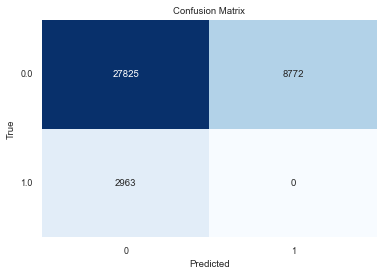

Random-forest
Train Score :  1.0
Test Score :  0.47146107178968655


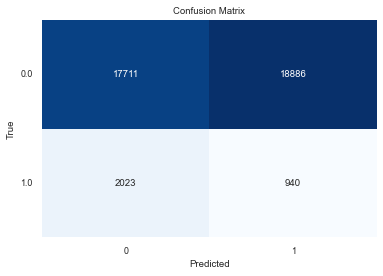

GradBoost
Train Score :  0.9999747238581503
Test Score :  0.5811678463094034


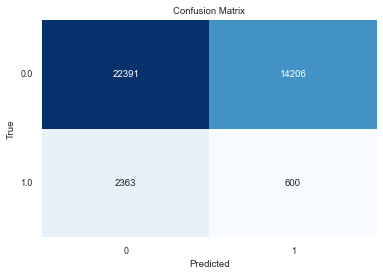

XGBoost
[10:44:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.3262386248736097


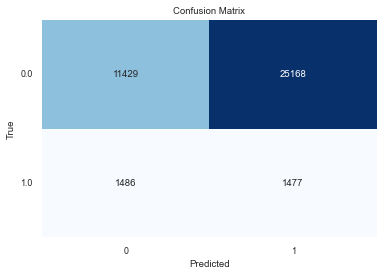

Logistic
Train Score :  0.9539198463152307
Test Score :  0.7944641051567239


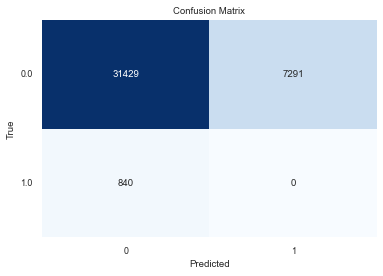

Random-forest
Train Score :  1.0
Test Score :  0.18796764408493427


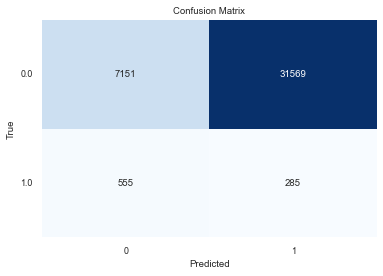

GradBoost
Train Score :  0.9963095433691846
Test Score :  0.20336198179979778


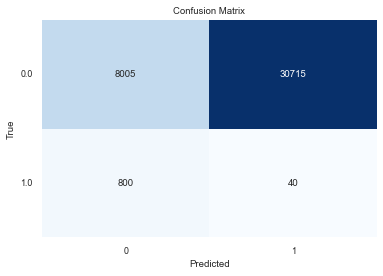

XGBoost
[10:45:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.2012133468149646


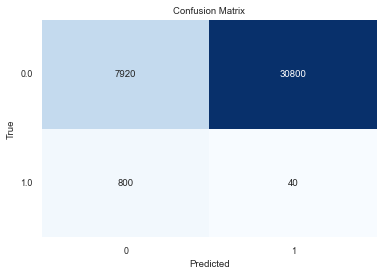

Logistic
Train Score :  0.9484509154638828
Test Score :  0.8359959555106168


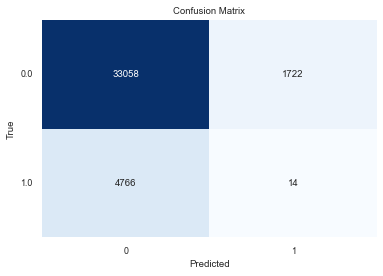

Random-forest
Train Score :  1.0
Test Score :  0.7974721941354904


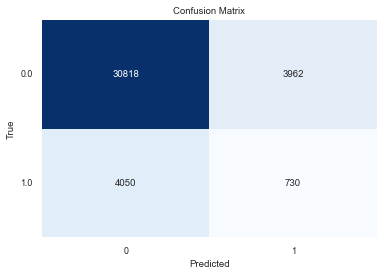

GradBoost
Train Score :  0.9901586579375311
Test Score :  0.8273003033367038


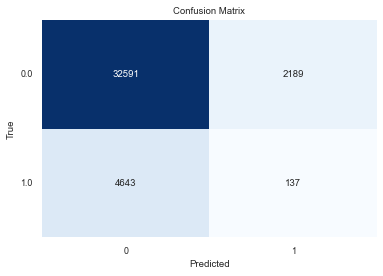

XGBoost
[10:46:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.8297017189079878


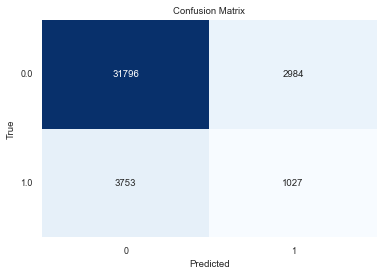

In [8]:
# List of classifiers that we would like to test    
models = {
    'Logistic': LogisticRegression(random_state = 1),
    'Random-forest': RandomForestClassifier(random_state = 1),
    'GradBoost': GradientBoostingClassifier(random_state=1),
    'XGBoost' : xgb.XGBClassifier(random_state=1)
         }


tscv = TimeSeriesSplit(n_splits=3)
X_train.index = range(len(X_train))
y_train.index = range(len(y_train))
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
    for  k, v in models.items():
        print(k)
        fitted_model = v.fit(X_tr,y_tr)
        print('Train Score : ', score(fitted_model, X_tr, y_tr))
        print('Test Score : ', score(fitted_model, X_val, y_val))
        conf_matrix(fitted_model, X_val, y_val)

Checking the results of the different models, we can see that the imbalance in the data is causing the classification to be off.Also, models are overfitting as scores from the train set are much higher of those calculated on the validation set. Results from the XGboost model seem to be slightly better than the other models. Although the algorithm performs well in general, even on imbalanced classification datasets, it offers a way to tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution.

As a next step we will tune the xgboost model to improve its results: 

sample_weight parameter is useful for handling imbalanced data while using XGBoost for training the data. We will compute sample weights by using compute_sample_weight() of sklearn library.

[10:47:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.372901921132457


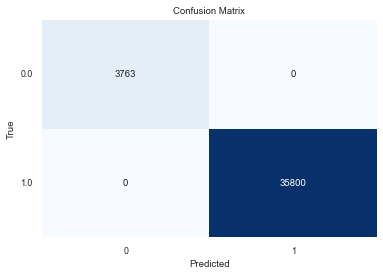

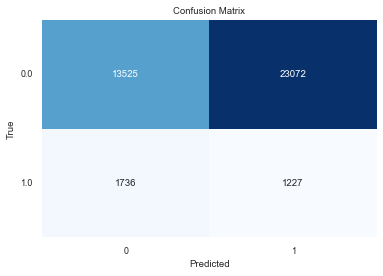

[10:47:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.2275278058645096


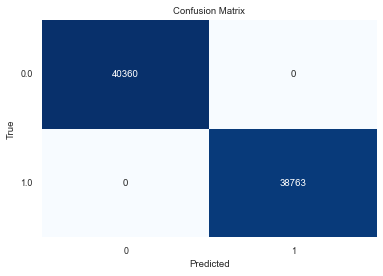

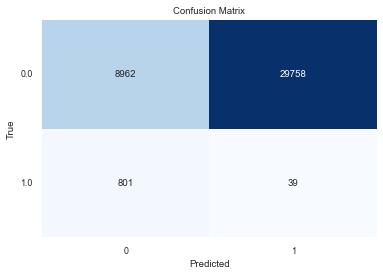

[10:47:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.8207785642062689


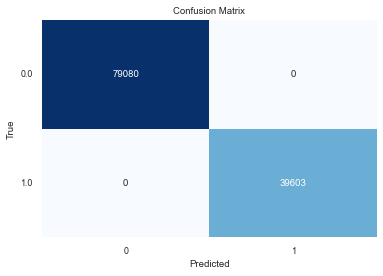

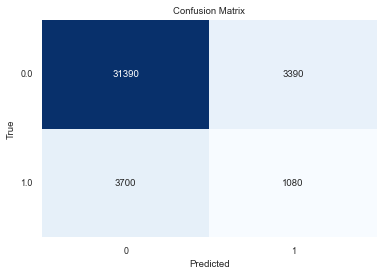

In [9]:
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
    sample_weights = compute_sample_weight(class_weight='balanced',y = y_tr)
    model = xgb.XGBClassifier(booster='gbtree',seed=0,nthread=-1,
                              gamma=0,scale_pos_weight=9,learning_rate=1,n_estimators=100,
                              max_depth=5,objective='binary:logistic',subsample=1)
    fitted_model = model.fit(X_tr,y_tr,sample_weight=sample_weights)
    print('Train Score : ', score(fitted_model, X_tr, y_tr))
    print('Test Score : ', score(fitted_model, X_val, y_val))
    conf_matrix(fitted_model, X_tr, y_tr)
    conf_matrix(fitted_model, X_val, y_val)

Adding the compute_sample_weigh and scale_pos_weigh parameters of xgboost did not help improve the results. We will do further tuning of the model by defining a grid of hyperparameters and run a RandomizedSearchCV to see which configuration of xgboost gives the best scores on our dataset.

In [10]:
def tuned_xgb_model(X , y , imbalance = True):
    
    if imbalance:
        spw = [1,5,10,20]
    else:
        spw = 1
    
    xgb_model = xgb.XGBClassifier(objective = 'binary:logistic')
    
    param_grid = {'n_estimators': stats.randint(150, 500),
                  'learning_rate': stats.uniform(0.01, 0.5),
                  'subsample': stats.uniform(0.3, 0.7),
                  'max_depth': [3, 5, 7, 9],
                  'colsample_bytree': stats.uniform(0.5, 0.45),
                  'scale_pos_weight': spw,
                  'min_child_weight': [1, 2, 3]
                  }
    
    clf = RandomizedSearchCV(xgb_model, param_distributions = param_grid, n_iter = 3, scoring = 'precision', error_score = 0, verbose = 3, n_jobs = -1)

    Folds = 5
    folds = KFold(n_splits = Folds, shuffle = False)
    estimators = []
    results = np.zeros(len(X))
    score = 0.0
    
    for train_index, test_index in folds.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        clf.fit(X_train, y_train)
        estimators.append(clf.best_estimator_)
        results[test_index] = clf.predict(X_test)
        score += precision_score(y_test, results[test_index])
    score /= Folds
    
    return estimators,  score

estimators,  mean_score = tuned_xgb_model(X = X_train, y = y_train)


best_xgb = estimators[3]
print('Mean score:',mean_score)
best_xgb.get_params()




Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:48:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:52:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:54:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7541411470199301,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.45355492646581186,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 250,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 5,
 'subsample': 0.5487787001451838,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Train Score :  0.9518525306016696
Test Score :  0.7562259615384616


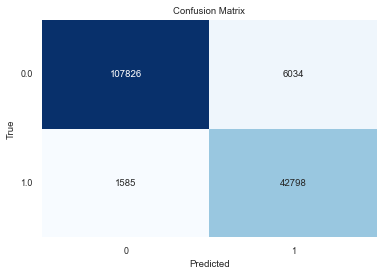

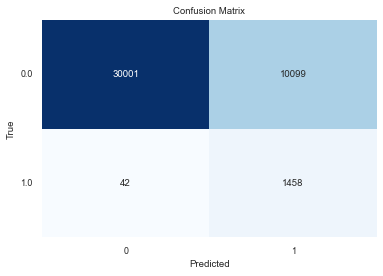

Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86     40100
         1.0       0.13      0.97      0.22      1500

    accuracy                           0.76     41600
   macro avg       0.56      0.86      0.54     41600
weighted avg       0.97      0.76      0.83     41600



In [11]:
print('Train Score : ', score(best_xgb,X_train,y_train))
print('Test Score : ', score(best_xgb,X_test,y_test))
conf_matrix(best_xgb, X_train, y_train)
conf_matrix(best_xgb, X_test, y_test)
# Compute classification report
report = classification_report(y_test, best_xgb.predict(X_test))
print("Report: \n",report)

Another Approach to deal with unbalanced data is to perform undersampling/oversampling techniques.

First, undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets.

[10:59:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.9720432692307692


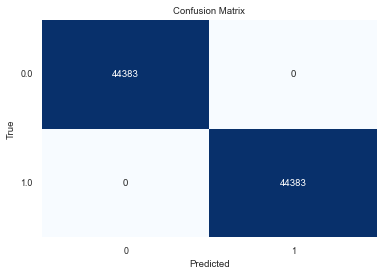

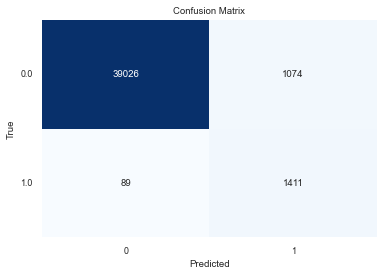

Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     40100
         1.0       0.57      0.94      0.71      1500

    accuracy                           0.97     41600
   macro avg       0.78      0.96      0.85     41600
weighted avg       0.98      0.97      0.98     41600



In [12]:
def undersample(df, SEED = SEED):

    class_0, class_1 = df['Tacking'].value_counts()

    df_0 = df[df['Tacking'] == 0]
    df_1 = df[df['Tacking'] == 1]
    
    df_0_under = df_0.sample(class_1)
    df_under = pd.concat([df_0_under, df_1], axis=0)
    
    return df_under    


train_data_under = undersample(train_data)
test_data_under = test_data


X_train_under = train_data_under.drop(['Tacking','DateTime'], axis=1)
y_train_under = train_data_under[['Tacking']]

X_test_under = test_data_under.drop(['Tacking','DateTime'], axis=1)
y_test_under = test_data_under[['Tacking']]

scaler = StandardScaler()
X_train_under = pd.DataFrame(scaler.fit_transform(X_train_under),columns = X_train_under.columns, index=X_train_under.index)
X_test_under = pd.DataFrame(scaler.transform(X_test_under),columns = X_test_under.columns, index=X_test_under.index)

model = xgb.XGBClassifier(booster='gbtree',seed=0,nthread=-1,
                              gamma=0,scale_pos_weight=7,learning_rate=0.75,n_estimators=50,
                              max_depth=5,objective='binary:logistic',subsample=1)
fitted_model_under  = model.fit(X_train_under,y_train_under)
print('Train Score : ', score(fitted_model_under,X_train_under,y_train_under))
print('Test Score : ', score(fitted_model_under,X_test_under,y_test_under))
conf_matrix(fitted_model_under, X_train_under, y_train_under)
conf_matrix(fitted_model_under, X_test_under, y_test_under)
# Compute classification report
report = classification_report(y_test_under, fitted_model_under.predict(X_test_under))
print("Report: \n",report)



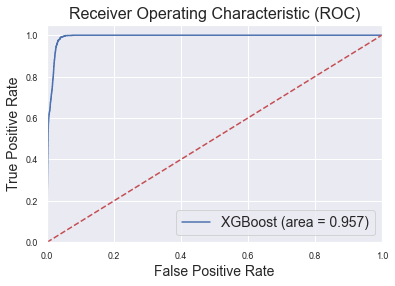

In [13]:
plot_rocinfo(fitted_model_under,X_test_under,y_test_under)

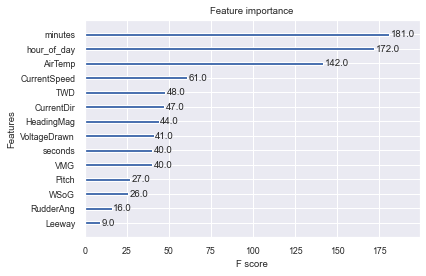

In [14]:
# we want to study the top features used by the model 
from xgboost import plot_importance
# plot feature importance
plot_importance(fitted_model_under)
plt.show()

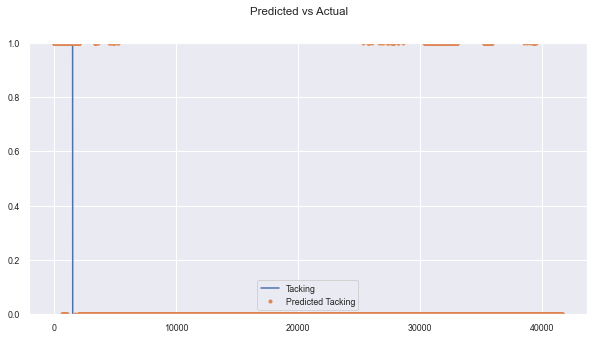

In [15]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
l = pd.concat([test_data_under['Tacking'].reset_index(drop=True),pd.DataFrame(fitted_model_under.predict(X_test_under),columns=['Predicted Tacking']).reset_index(drop=True)], axis=1)

_ = l.plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 1)
plot = plt.suptitle('Predicted vs Actual')

[10:59:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score :  1.0
Test Score :  0.978125


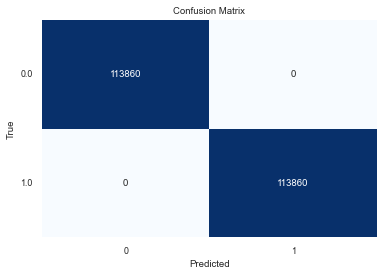

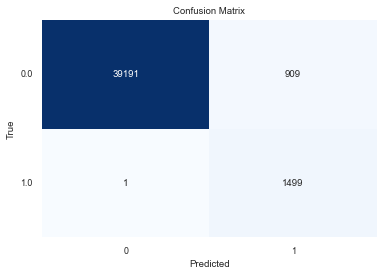

Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     40100
         1.0       0.62      1.00      0.77      1500

    accuracy                           0.98     41600
   macro avg       0.81      0.99      0.88     41600
weighted avg       0.99      0.98      0.98     41600



In [16]:
def oversample(df, SEED = SEED):

    class_0, class_1 = df['Tacking'].value_counts()

    df_0 = df[df['Tacking'] == 0]
    df_1 = df[df['Tacking'] == 1]
    
    df_1_over = df_1.sample(class_0,replace = True)
    df_over = pd.concat([df_1_over, df_0], axis=0)
    
    return df_over    


train_data_over = oversample(train_data)
test_data_over = test_data


X_train_over = train_data_over.drop(['Tacking','DateTime'], axis=1)
y_train_over = train_data_over[['Tacking']]

X_test_over = test_data_over.drop(['Tacking','DateTime'], axis=1)
y_test_over = test_data_over[['Tacking']]

scaler = StandardScaler()
X_train_over = pd.DataFrame(scaler.fit_transform(X_train_over),columns = X_train_over.columns, index=X_train_over.index)
X_test_over = pd.DataFrame(scaler.transform(X_test_over),columns = X_test_over.columns, index=X_test_over.index)

model = xgb.XGBClassifier(booster='gbtree',seed=0,nthread=-1,
                              gamma=0,scale_pos_weight=7,learning_rate=0.75,n_estimators=50,
                              max_depth=5,objective='binary:logistic',subsample=1)
fitted_model_over  = model.fit(X_train_over,y_train_over)
print('Train Score : ', score(fitted_model_over,X_train_over,y_train_over))
print('Test Score : ', score(fitted_model_over,X_test_over,y_test_over))
conf_matrix(fitted_model_over, X_train_over, y_train_over)
conf_matrix(fitted_model_over, X_test_over, y_test_over)
# Compute classification report
report = classification_report(y_test_over, fitted_model_over.predict(X_test_over))
print("Report: \n",report)


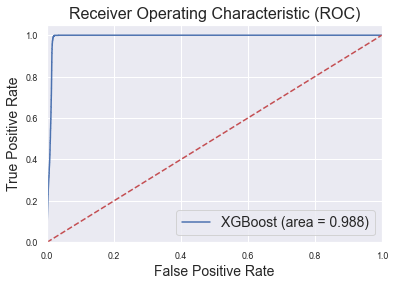

In [17]:
plot_rocinfo(fitted_model_over,X_test_over,y_test_over)

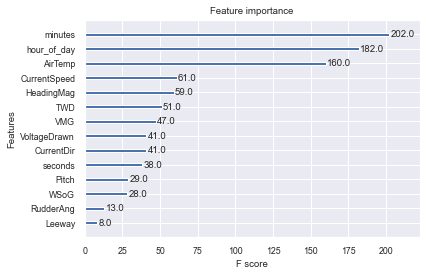

In [18]:
# we want to study the top features used by the model 
from xgboost import plot_importance
# plot feature importance
plot_importance(fitted_model_over)
plt.show()

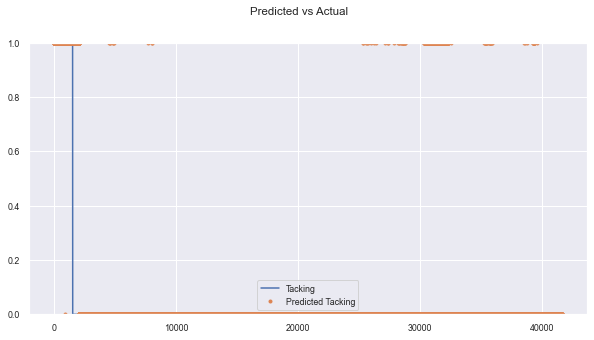

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
l = pd.concat([test_data_over['Tacking'].reset_index(drop=True),pd.DataFrame(fitted_model_over.predict(X_test_over),columns=['Predicted Tacking']).reset_index(drop=True)], axis=1)

_ = l.plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 1)
plot = plt.suptitle('Predicted vs Actual')

### Conclusion : 
   
   Both of the approaches ( Tuned XGboost Model and under/oversampled data Model ) are giving reasonbly good results in terms of score. Thus looking at the classification report for the prediction of the class 1 'Tacking', we see relatively low precision and recall compared to class 1, which means that a large number of our "positive" predictions are wrong. What does that mean for the tack prediction application ? The model recommends doing tacking when it should not do it. The question that we should be investigating is: what is the potential cost of a missclassification of class 1 in the tack prediction? Although, this is a common problem in imbalanced datasets such as those of fraud detection and anomaly detection, other improvements can be made, such as trying non-tree based models such as neural netwroks (LSTM, etc.) or even adding more features that describe more the tack events over time, such as lag features and window features.